In [2]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format',lambda x : '%.5f' % x)
pd.set_option('display.width', 500)    #设置整体宽度
from mtools import plot_fig
import matplotlib.pyplot as plt
import seaborn as sns
from mtools import monkey as mk

os.chdir('/data/wjk/Workspace/Datasets/IGR')
IGR_DIRS = ['IGR', 'IGR230307', 'IGR230312']
IGR_DIR = 'IGR230307'

In [16]:
all_imu_data = pd.read_hdf(f'Output/all_imu_data_{IGR_DIR}.h5', 'all_imu')
phones = all_imu_data['phone'].unique()
trips = all_imu_data['trip'].unique()
all_imu_data['AccU'] = all_imu_data['AccU'] - 9.8

In [29]:
all_imu_data.columns

Index(['timestamp', 'elapsedRealtimeNanos', 'AccX', 'AccY', 'AccZ', 'Source',
       'AccE', 'AccN', 'AccU', 'GysX', 'GysY', 'GysZ', 'GysE', 'GysN', 'GysU',
       'MagX', 'MagY', 'MagZ', 'yawDeg', 'rollDeg', 'pitchDeg', 'phone',
       'trip'],
      dtype='object')

In [26]:
# Normalization
IGR_DIRS = ['IGR', 'IGR230307', 'IGR230312']
for IGR_DIR in IGR_DIRS:
    all_imu_data = pd.read_hdf(f'Output/all_imu_data_{IGR_DIR}.h5', 'all_imu')
    phones = all_imu_data['phone'].unique()
    trips = all_imu_data['trip'].unique()
    all_imu_data['AccU'] = all_imu_data['AccU'] - 9.8
    acc_values = all_imu_data[['timestamp', 'AccE', 'AccN', 'AccU']].melt(id_vars=['timestamp'], value_vars=['AccE', 'AccN', 'AccU'])['value']
    gyr_values = all_imu_data[['timestamp', 'GysE', 'GysN', 'GysU']].melt(id_vars=['timestamp'], value_vars=['GysE', 'GysN', 'GysU'])['value']
    acc_des = acc_values.astype('float64').describe(percentiles=[.01, 0.1, 0.2, .25, .75, .8, 0.9, 0.99]).to_frame().T
    gyr_des = gyr_values.astype('float64').describe(percentiles=[.01, 0.1, 0.2, .25, .75, .8, 0.9, 0.99]).to_frame().T
    mk.magic_append([acc_des, gyr_des])
acc_des, gyr_des = mk.magic_get(pd.concat)

In [38]:
# acc_des = pd.concat([_.to_frame().T for _ in acc_des_list])
# gyr_des = pd.concat([_.to_frame().T for _ in gyr_des_list])
print(acc_des)
print(gyr_des)
print(acc_des/gyr_des)

pd.concat((acc_des, gyr_des, acc_des/gyr_des)).to_csv('Output/acc_gyr_des.csv', float_format='%.2f')

             count    mean    std     min      1%     10%     20%     25%     50%    75%    80%    90%    99%     max
value 3140919.0000 -0.0183 0.9266 -5.3230 -2.0404 -1.1881 -0.7919 -0.6410 -0.0395 0.5669 0.7222 1.1635 2.3123  6.8191
value 3571221.0000  0.0303 1.6926 -8.5916 -3.8600 -2.1745 -1.3325 -1.0397  0.0455 1.0763 1.3415 2.1545 4.1981  9.6890
value 4574703.0000  0.0168 1.7239 -8.2248 -3.9348 -2.1339 -1.2603 -0.9984 -0.0286 0.9664 1.2317 2.1666 4.6839 10.7189
             count   mean    std     min      1%     10%     20%     25%     50%    75%    80%    90%    99%    max
value 3140919.0000 0.0023 0.2145 -1.6418 -0.5809 -0.2311 -0.1451 -0.1151 -0.0003 0.1162 0.1476 0.2410 0.6017 1.8589
value 3571221.0000 0.0013 0.3439 -1.7453 -0.8548 -0.4265 -0.2716 -0.2177  0.0049 0.2232 0.2756 0.4204 0.8400 1.8500
value 4574703.0000 0.0013 0.2918 -1.7018 -0.7103 -0.3707 -0.2363 -0.1866  0.0083 0.1920 0.2372 0.3596 0.6974 1.7279
       count    mean    std    min     1%    10%    20%    25%  

In [45]:
trip_id = 4
pre_duration = 0
duration = 1000
sub_dfs = [all_imu_data['timestamp'][(all_imu_data['trip']==trips[trip_id])&(all_imu_data['phone']==phone)].to_frame() for phone in phones]
start_timestamps = [sub_df.iloc[0] for sub_df in sub_dfs]
start_timestamp = np.max(start_timestamps) + pre_duration*100
start_timestamp_inds = [np.where(sub_df==start_timestamp)[0][0] for sub_df in sub_dfs]
print(start_timestamp_inds)
sub_dfs = [all_imu_data[(all_imu_data['trip']==trips[trip_id])&(all_imu_data['phone']==phone)].iloc[ind:ind+duration*100] for phone,ind in zip(phones, start_timestamp_inds)]
sub_df = pd.concat(sub_dfs)

[200, 900, 100, 0]


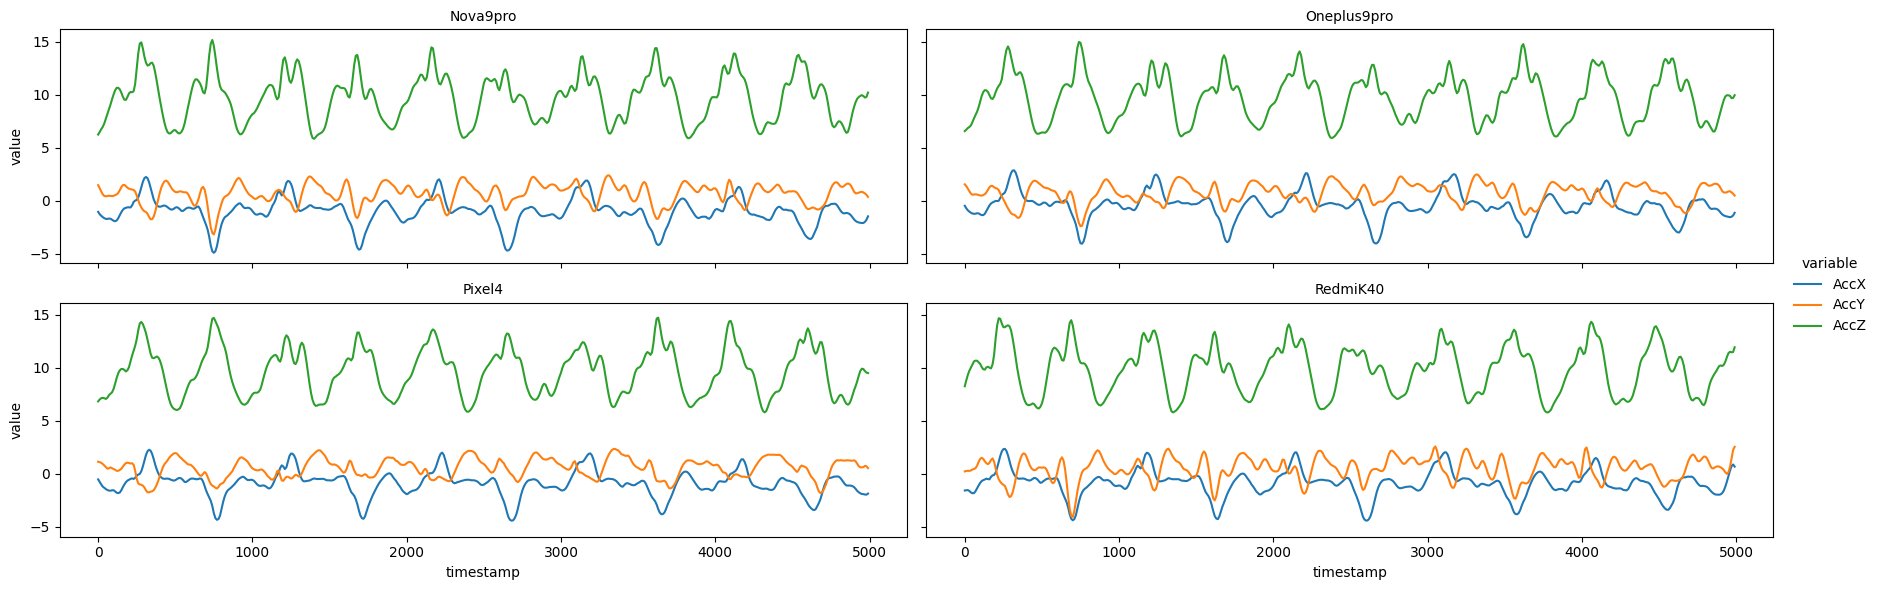

In [20]:
melt_sub_df = pd.melt(sub_df[['timestamp', 'AccX', 'AccY', 'AccZ', "phone"]], id_vars=['timestamp', 'phone'], value_vars=['AccX', 'AccY', 'AccZ'])
melt_sub_df['timestamp'] = melt_sub_df['timestamp']-np.min(melt_sub_df['timestamp'].values)

g = sns.FacetGrid(melt_sub_df, hue='variable', col="phone",  col_wrap=2, despine=False, aspect=3)
g.map(sns.lineplot, "timestamp", "value")
g.set_titles("{col_name}")
g.add_legend()
plt.show()
# g.savefig('Figures/err_scatter_byphone_new.png', dpi=150, pad_inches=0.2)

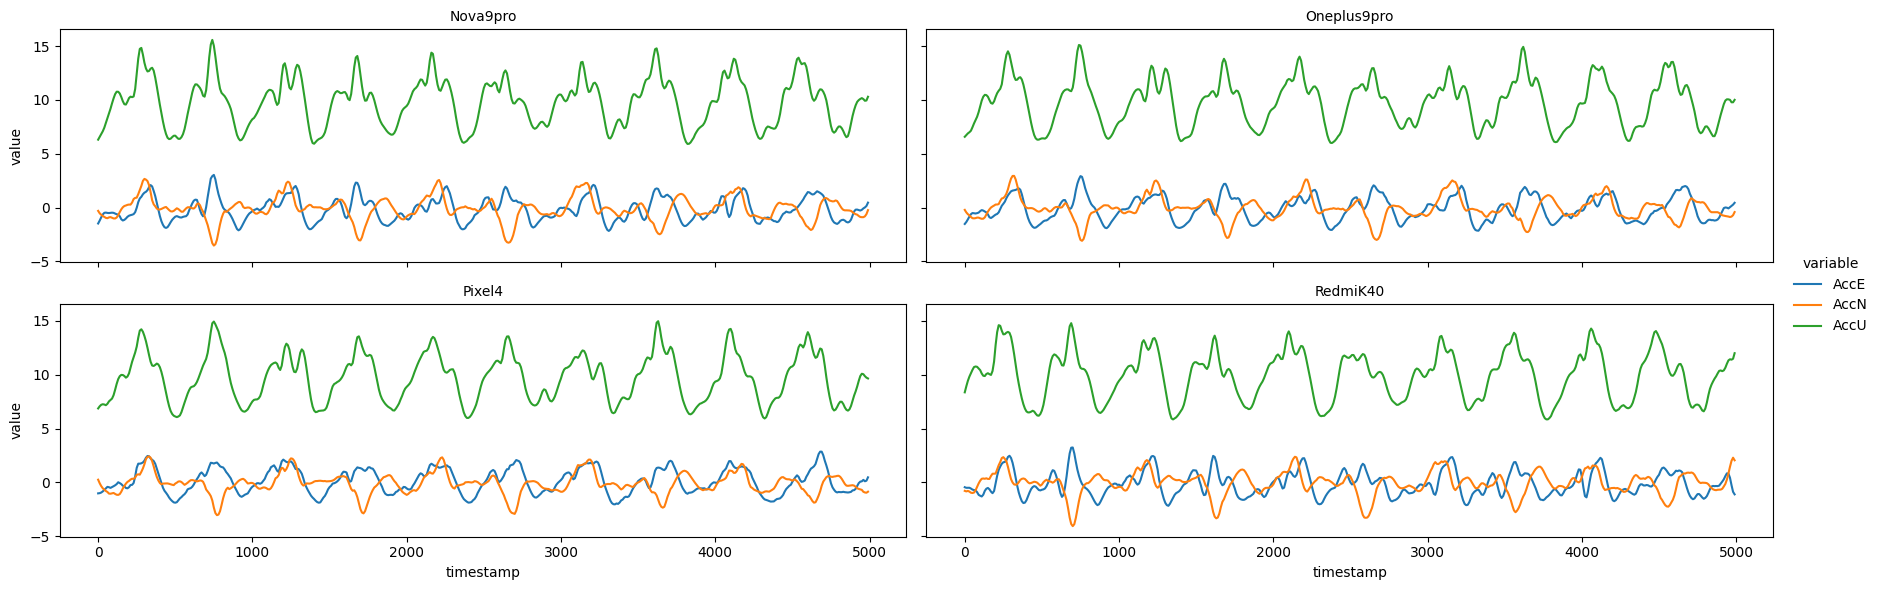

In [21]:
melt_sub_df = pd.melt(sub_df[['timestamp', 'AccE', 'AccN', 'AccU', "phone"]], id_vars=['timestamp', 'phone'], value_vars=['AccE', 'AccN', 'AccU'])
melt_sub_df['timestamp'] = melt_sub_df['timestamp']-np.min(melt_sub_df['timestamp'].values)
g = sns.FacetGrid(melt_sub_df, hue='variable', col="phone",  col_wrap=2, despine=False, aspect=3)
g.map(sns.lineplot, "timestamp", "value")
g.set_titles("{col_name}")
g.add_legend()
plt.show()

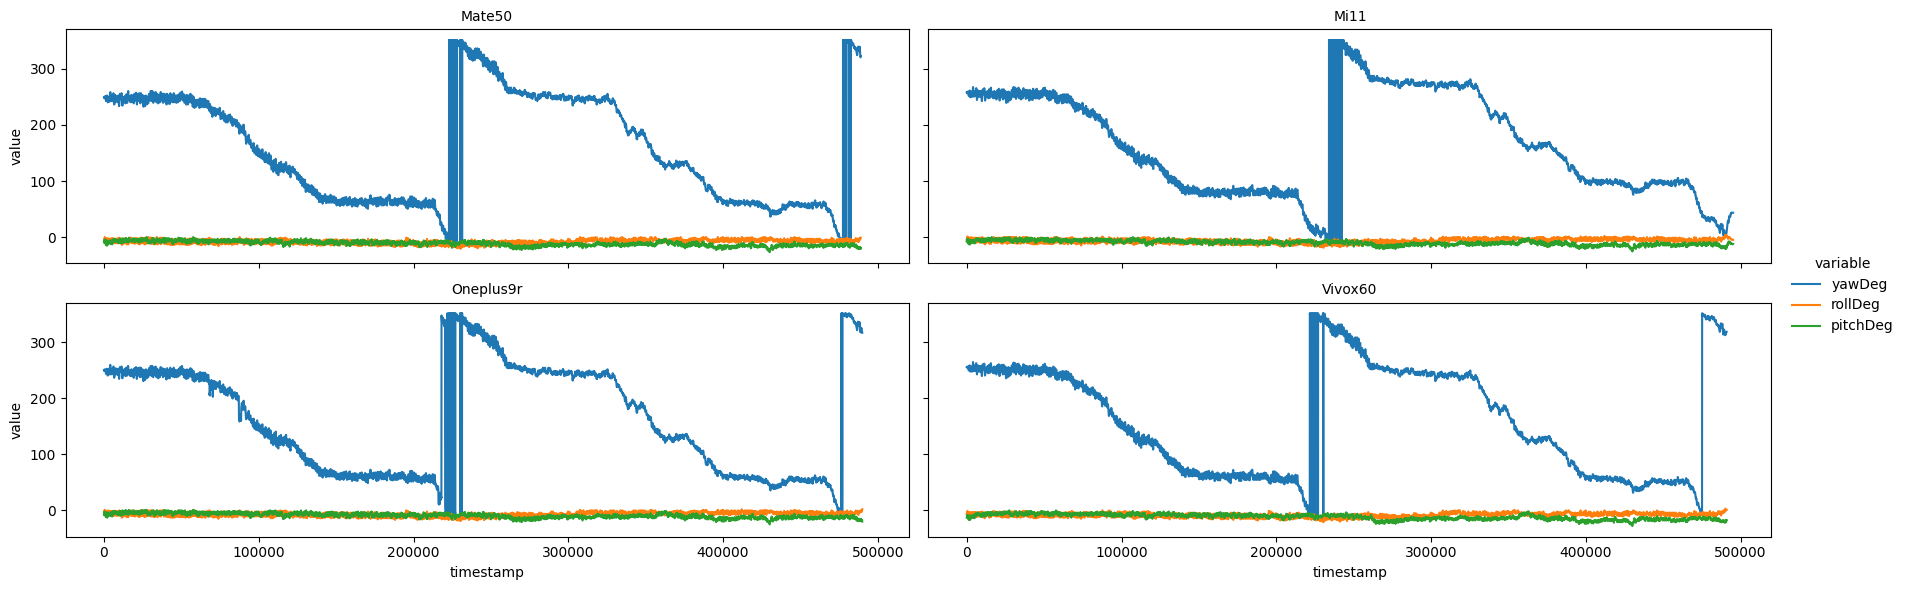

In [46]:
melt_sub_df = pd.melt(sub_df[['timestamp', 'yawDeg', 'rollDeg', 'pitchDeg', "phone"]], id_vars=['timestamp', 'phone'], value_vars=['yawDeg', 'rollDeg', 'pitchDeg'])
melt_sub_df['timestamp'] = melt_sub_df['timestamp']-np.min(melt_sub_df['timestamp'].values)

g = sns.FacetGrid(melt_sub_df, hue='variable', col="phone",  col_wrap=2, despine=False, aspect=3)
g.map(sns.lineplot, "timestamp", "value")
g.set_titles("{col_name}")
g.add_legend()
plt.show()
# g.savefig('Figures/err_scatter_byphone_new.png', dpi=150, pad_inches=0.2)

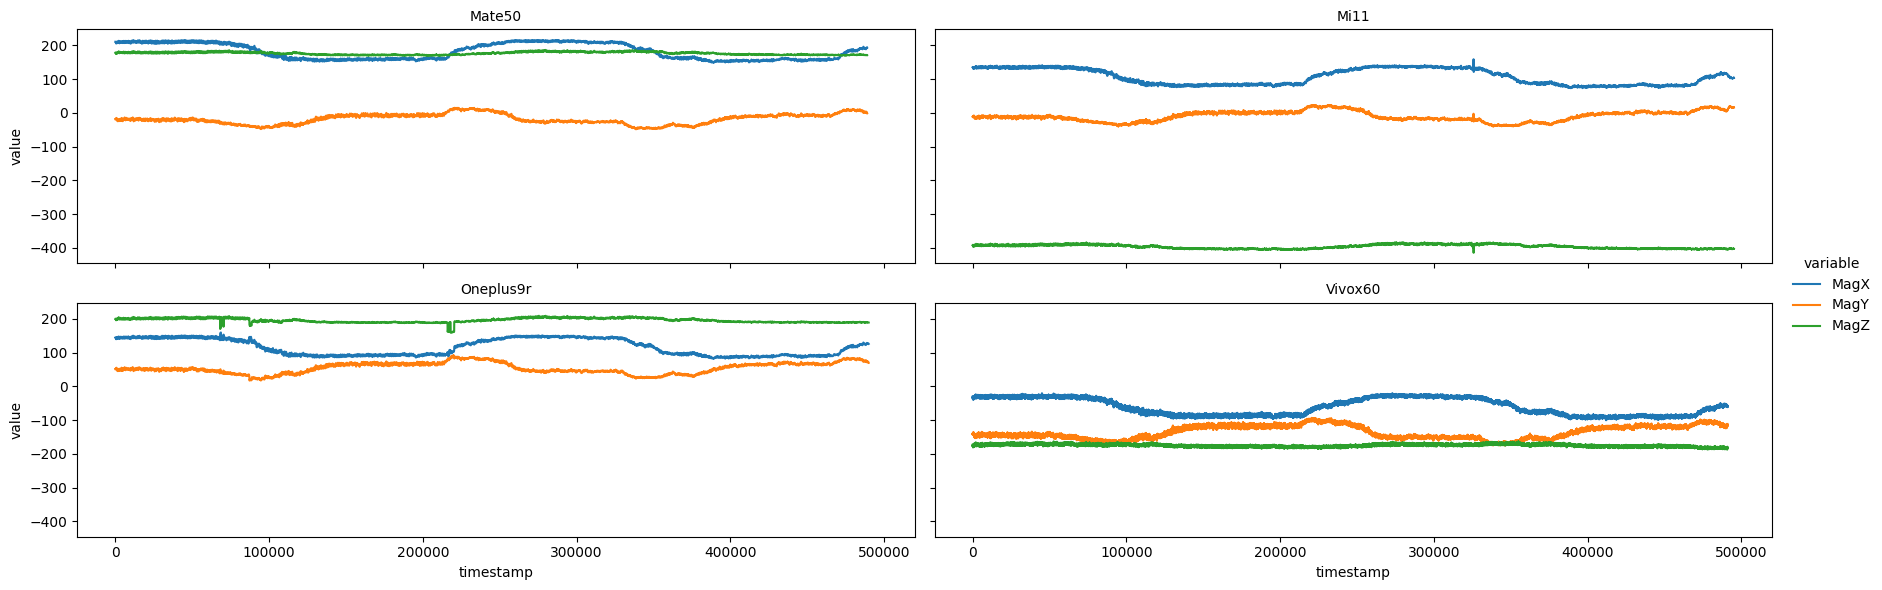

In [47]:
melt_sub_df = pd.melt(sub_df[['timestamp', 'MagX', 'MagY', 'MagZ', "phone"]], id_vars=['timestamp', 'phone'], value_vars=['MagX', 'MagY', 'MagZ'])
melt_sub_df['timestamp'] = melt_sub_df['timestamp']-np.min(melt_sub_df['timestamp'].values)

g = sns.FacetGrid(melt_sub_df, hue='variable', col="phone",  col_wrap=2, despine=False, aspect=3)
g.map(sns.lineplot, "timestamp", "value")
g.set_titles("{col_name}")
g.add_legend()
plt.show()
# g.savefig('Figures/err_scatter_byphone_new.png', dpi=150, pad_inches=0.2)